# ランダムフォレスト
ランダムフォレストアルゴリズムによる分類モデルを構築。また** K分割交差検証 **をキャッチアップ。

1. ランダムフォレストについて
2. データ取得
3. 前処理について
4. EDA
5. 学習
6. ハイパーパラメータチューニング
7. K分割交差検証
8. 特徴量の重要度

## 1. ランダムフォレストについて

ランダムフォレストは** 複数の決定木モデルを集めて構成されたモデル **を使って、確率を算出する方法であり、アンサンブル学習のひとつである。  
※ 決定木とは、**目的変数に属する確率を複数の説明変数の組み合わせで算出 **する方法

またランダムフォレストは学習の際、説明変数をランダムに選んで、各決定木モデルを作成する。
- 説明変数どうしに相関があると、弱学習器（決定木）間にも相関が生まれ、別のデータで予測すると誤差が発生する。（汎用性がない）  
- 説明変数をランダムに選ぶことで、相関の低い決定木群を作成し、別データでの誤差を下げ、汎用性を保持

**メリット**  
- ノイズに強い
- 高精度・表現力も高い
- 並列化が容易→データ量が多くても高速に動く
- どの特徴量が重要かを知ることができる

**デメリット**  
- パラメータが多い（木の数や使用する説明変数の数）
- データと説明変数をランダム抽出するため、データと変数が少なすぎるとうまく学習できない
- 複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる

## 2. データ取得
データセット：Titanic: Machine Learning from Disaster  
https://www.kaggle.com/c/titanic/data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [27]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


- 総データ数：891
- 欠損値あり
 - Age（年齢）
 - Cabin（客席）
 - Embarked（乗船港）
- 目的変数
 - Survived：数値
- 説明変数
 - Pclass：数値
 - Name：カテゴリカル値
 - Sex：カテゴリカル値
 - Age：数値
 - SibSp：数値
 - Parch：数値
 - Ticket：カテゴリカル値
 - Fare：数値
 - Cabin：カテゴリカル値
 - Embarked：カテゴリカル値




## 3. 前処理

前処理とは、機械学習アルゴリズムで構築されたモデルでの**分析を正常に稼働させる**ため、取得データを**各値の関係性を損ねることなく加工**する作業であり、学習速度を早めたり、モデルの精度を高めたりすることができる。

具体的には、

**1. 欠損値補完**  
取得データにnull値があると、モデルにデータが渡せないので、最適な数値に変換する必要がある。（カテゴリカル値の場合は、適当な文字列に変換）
- データ数が多く、欠損値のあるデータが限りなく少ない場合、データごと削除（**リストワイズ法**）
- 値がランダムに欠損しているということが確認できている場合、カラムの平均を欠損値に代入（**平均代入法**）
- 上記いずれにも該当しない場合、連鎖方程式（MICE）による多重代入法で、欠損値を補完

**2. カテゴリカル値のエンコーディング（数値化）**  
取得データにカテゴリカル値があると、モデルにデータが渡せないので、最適な数値に変換する必要がある。
- カテゴリカル値が尺度や順位を意味している場合、各分類を数値に変換
- カテゴリカル値が名義である場合、カテゴリカル値の分類数分のカラムを増やし、バイナリ真理値（one-hot表現）に変換

**3. スケーリング**  
範囲の大きい特徴量に影響を受けすぎることによる過学習を防ぐため、数的関係を損ねることなく、数値の範囲を統一させる必要がある。
- データに外れ値がなく、一様分布の場合、0〜1 の範囲に正規化させる。
- 上記以外の場合、平均が 0、標準偏差が 1 に標準化させる。

### データを確認する際の注意点
1. ** 欠損値の有無 **を確認。データ数が多く、欠損値データが限りなく少ない場合はデータ削除。でなければ、欠損値に数値を補完。  
2. ** データのタイプ **を確認。カテゴリカル値が見つかれば、エンコーディングを実施。  
3. フィーチャースケーリングするために** データの分布 **を確認。
 - 正規分布に従っているなら標準化
 - 一様分布（外れ値がない画像データなど）なら正規化

### 前処理実施

In [30]:

# 年齢という具体的な数値に対して、過度に影響を受けないようにするため、年齢層にグループ分け
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

# null値のままでは、モデルにデータを渡せないため、まずカテゴリカルの欠損値を文字列に変換（この後のencode_featuresで数値データに変換できる）
# 部屋番号という具体的な数値に対して、過度に影響を受けないようにするため、部屋番号をグループ分け
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

# 乗船料金という具体的な数値に対して、過度に影響を受けないようにするため、料金帯にグループ分け
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

#「名前」を「姓」と「接頭辞」に分割し、それぞれの新たな説明変数を増設（新たな特徴量を増設することで、モデルの精度を向上させる）
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

# 生存率に関わりのない「名前」「乗客ID」「乗船した港」のカラムを削除
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [31]:
pre_train_df = transform_features(train_df)
pre_test_df = transform_features(test_df)

In [32]:
pre_train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [33]:
pre_test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,N,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,N,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,N,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,N,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,N,"Hirvonen,",Mrs.


In [34]:
from sklearn import preprocessing

# 乗船料金、部屋番号、年齢、性別、姓、名前接頭辞の各カテゴリカルグループを数値に変換
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

In [35]:
pre_train_df, pre_test_df = encode_features(pre_train_df, pre_test_df)

In [36]:
pre_train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [37]:
pre_test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


## 4. EDA

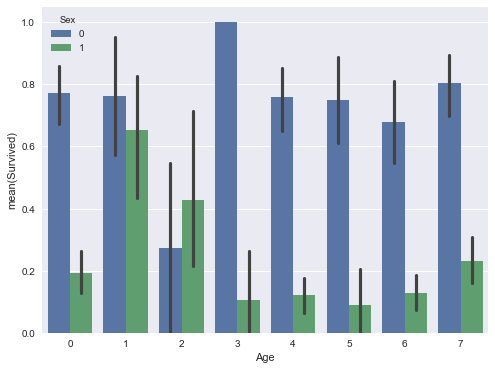

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(x="Age", y="Survived", hue="Sex", data=pre_train_df)
plt.show()

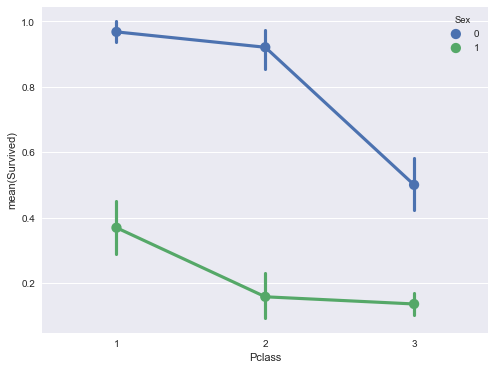

In [40]:
plt.figure(figsize=(8,6))
sns.pointplot(
    x="Pclass",
    y="Survived",
    hue="Sex",
    data=pre_train_df
)
plt.show()

- 全体を通して、男性よりも女性の生存率が高い
- 乳幼児生存率は男女ともに高い
- こどもの生存率は男性が高く、それ以外の年齢層はいずれも女性が圧倒的に高い
- 高客室であるほど生存率が高い

以上のことから、** 性別とクラスをあわせた説明変数を追加 **することで、より精度があがる可能性がある。

## 5. 学習
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### データセット分割

In [41]:
# 説明変数
X = pre_train_df.drop(['Survived', 'PassengerId'], axis=1)
# 目的変数
y = pre_train_df['Survived']

# データセット分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=25,
    random_state=0
)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

n_estimators：決定木（分類器）の数

In [43]:
# トレインデータのaccuracy
clf.score(X_train, y_train)

0.9929775280898876

In [44]:
# テストデータの予測値
clf.predict(X_test)

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0])

In [45]:
# テストデータのaccuracy
clf.score(X_test,y_test)

0.7932960893854749

## 6. ハイパーパラメータチューニング
グリッドサーチによるハイパーパラメータチューニングを実行し、モデルの精度を上げる。  
https://qiita.com/tomov3/items/039d4271ed30490edf7b

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [4, 6, 9],
    'max_features': ['log2', 'sqrt','auto'],
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1,5,8]
}
forest = RandomForestClassifier(
    random_state = 0
)
grid_search = GridSearchCV(
    estimator = forest,
    param_grid = params,
    scoring = 'accuracy',
    cv = 10
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [4, 6, 9], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
#grid_search.grid_scores_

In [48]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 6}

In [49]:
grid_search.best_score_

0.8314606741573034

チューニング前に比べて、モデルの精度が上がったことが確認できた。

In [50]:
# ハイパーパラメーターチューニング後の推定器
clf = RandomForestClassifier(
    criterion = 'gini',
    max_depth = 10,
    max_features = 'log2',
    min_samples_leaf = 1,
    min_samples_split = 5,
    n_estimators = 6,
    random_state = 0
)
# 学習
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 7. K分割交差検証

### 検証について
検証とは、**モデルの汎用性チェック **のことである。  
いくらモデルのAccuracyが高くても、それは取得データ内での正解率であり、  
限られたデータ以外でも、正常に正解を出力できるか確認しなければならない。

主な検証方法として、下記が挙げられる。
- ホールドアウト法
- K分割交差検証

### K分割交差検証（KFold）について
K分割交差検証とはトレーニングデータをk分割し、k-1個を学習用に残りをテストに使用  
これにより、k回の学習とテストを行うことができ、それらの平均と標準偏差を算出する。  
通常kの値は10前後になり、データが多い場合はkの値を減らした方が良い。  
但し、k値を大きくし過ぎると過学習が高くなり、逆にk値を低くしすぎると未学習の可能性がある。

### KFold実施
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [51]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# K分割交差検証：回帰問題
# kfold = KFold(n_splits=10, random_state=0)
# 層化K分割交差検証（各分割内でのクラスの比率が全体の比率と同じになるように分割）：分類問題
stratifiedkfold = StratifiedKFold(n_splits=10, random_state=0)

# scores：各Foldのスコアを出力
scores = cross_val_score(
    estimator=clf, # 推定器
    X=X_train,
    y=y_train,
    cv=stratifiedkfold, # 分割数または交差検証
    scoring="accuracy", # 評価指標
    n_jobs=1 # CPU数（-1に設定すると、すべてのCPUで並列処理）
)

for i,s in enumerate(scores):
    print("Fold: {}, Acc: {}".format(i+1,s))
    print( '-'*100)
    
print('Mean: {:.3f}, Std: {:.3f}' .format(np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.8611111111111112
----------------------------------------------------------------------------------------------------
Fold: 2, Acc: 0.8472222222222222
----------------------------------------------------------------------------------------------------
Fold: 3, Acc: 0.8055555555555556
----------------------------------------------------------------------------------------------------
Fold: 4, Acc: 0.8450704225352113
----------------------------------------------------------------------------------------------------
Fold: 5, Acc: 0.8309859154929577
----------------------------------------------------------------------------------------------------
Fold: 6, Acc: 0.8169014084507042
----------------------------------------------------------------------------------------------------
Fold: 7, Acc: 0.7887323943661971
----------------------------------------------------------------------------------------------------
Fold: 8, Acc: 0.8169014084507042
-----------------------------

平均 accuracy は高く、標準偏差も低いことから、（限られたデータ内ではあるが）汎用性のある、精度の高いモデルと判断できる。

## 8. 特徴量の重要度

In [52]:
clf.feature_importances_

array([0.07722624, 0.28009661, 0.05949   , 0.06577989, 0.02081238,
       0.0427546 , 0.10628914, 0.18963909, 0.15791205])

In [53]:
importance_df=pd.DataFrame(data=clf.feature_importances_, columns=["importance"], index=X_train.columns)
importance_df=importance_df.sort_values('importance', ascending=False)
importance_df

,importance
Sex,0.280097
Lname,0.189639
NamePrefix,0.157912
Cabin,0.106289
Pclass,0.077226
SibSp,0.065780
Age,0.059490
Fare,0.042755
Parch,0.020812


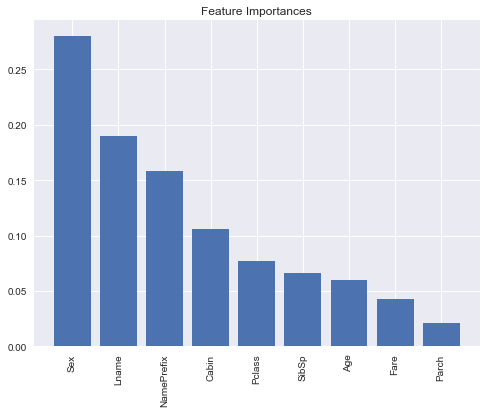

In [55]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.bar(range(len(importance_df)),importance_df["importance"])
plt.xticks(range(len(importance_df)), importance_df.index, rotation=90)
plt.show()

性別の重要度が最も高く、名字、敬称、客席、クラスと続く。